# Machine Learning

## Homework IV

Using Tensorflow/Keras as exemplified in practical lecture 9, explore the use of different
neural network architectures to achieve the highest performance on the test set of the famous
MNIST data set (http://yann.lecun.com/exdb/mnist/).

Let's start by importing the libraries that will be used in this exercise:

* [tensorflow](https://www.tensorflow.org/): the neural network library
* [tensorflow_datasets](https://www.tensorflow.org/datasets): provides the datasets that we will use
* [numpy](https://numpy.org/): we will use it to store the data in array format for visualization
* [sklearn](https://scikit-learn.org/): provides a [PCA](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) implementation that we will use for visualization
* [matplotlib](https://matplotlib.org/): plotting library for visualization

In [0]:
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras import layers
from tensorflow.keras import regularizers
import numpy as np

import sklearn.decomposition
import matplotlib.pyplot as plt

### Dataset
We will use the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset throught this exercise, which is widely used for introducing image classification problems: 

* 70k examples of handwritten digits
* Image size: 28x28
* 1 channel
* 10 classes: [0-9]

In [0]:
mnist_data, mnist_info = tfds.load('mnist', with_info=True)

local data directory. If you'd instead prefer to read directly from our public
GCS bucket (recommended if you're running on GCP), you can instead set
data_dir=gs://tfds-data/datasets.





Dataset mnist downloaded and prepared to /root/tensorflow_datasets/mnist/3.0.0. Subsequent calls will reuse this data.


In [0]:
print(mnist_info)

tfds.core.DatasetInfo(
    name='mnist',
    version=3.0.0,
    description='The MNIST database of handwritten digits.',
    homepage='http://yann.lecun.com/exdb/mnist/',
    features=FeaturesDict({
        'image': Image(shape=(28, 28, 1), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=10),
    }),
    total_num_examples=70000,
    splits={
        'test': 10000,
        'train': 60000,
    },
    supervised_keys=('image', 'label'),
    citation="""@article{lecun2010mnist,
      title={MNIST handwritten digit database},
      author={LeCun, Yann and Cortes, Corinna and Burges, CJ},
      journal={ATT Labs [Online]. Available: http://yann. lecun. com/exdb/mnist},
      volume={2},
      year={2010}
    }""",
    redistribution_info=,
)



We can see that, in this case, the dataset has a standard partition of 60k examples for training and 10k for testing. Let's convert them to [NumPy](https://numpy.org/) arrays:

In [0]:
mnist_train_x = np.asarray([instance['image']/255 for instance in tfds.as_numpy(mnist_data['train'])])
mnist_train_y = np.asarray([instance['label'] for instance in tfds.as_numpy(mnist_data['train'])])

mnist_test_x = np.asarray([instance['image']/255 for instance in tfds.as_numpy(mnist_data['test'])])
mnist_test_y = np.asarray([instance['label'] for instance in tfds.as_numpy(mnist_data['test'])])

## Feed-Forward Networks

To explain how to create and train a neural network model using the [Keras API](https://www.tensorflow.org/api_docs/python/tf/keras), we will start by exploring feed-forward networks.

### Models

Now, let's create and train some networks to approach the problem posed by the [MNIST dataset](http://yann.lecun.com/exdb/mnist/). [Keras](https://www.tensorflow.org/api_docs/python/tf/keras) provides two ways to create a model: the [Sequential](https://www.tensorflow.org/api_docs/python/tf/keras/Sequential) model, in which the layers form a linear stack, and the [Functional API](https://www.tensorflow.org/guide/keras/functional), which is more flexible. 

#### Baseline: Single-Layer Network

We will start by creating a very simple network without hidden layers. Thus, in addition to the [input](https://www.tensorflow.org/api_docs/python/tf/keras/Input), it will only have a fully connected layer which, in the [Keras API](https://www.tensorflow.org/api_docs/python/tf/keras), is called a [Dense](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dense) layer. Since the dataset poses a multiclass classification problem, the layer will have a number of neurons equal to the number of classes and we will use the softmax [activation](https://www.tensorflow.org/api_docs/python/tf/keras/activations). The *name* parameter is optional for both the model and the layers, but it is useful in more complex scenarios.

In [38]:
mnist_baseline_model = tf.keras.Sequential(name='mnist_baseline')
mnist_baseline_model.add(tf.keras.layers.Input(mnist_info.features['image'].shape))
mnist_baseline_model.add(tf.keras.layers.Flatten(name='flatten'))
mnist_baseline_model.add(tf.keras.layers.Dense(mnist_info.features['label'].num_classes, activation='softmax', name='output'))
mnist_baseline_model.compile(loss='sparse_categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])
mnist_baseline_model.summary()

Model: "mnist_baseline"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
output (Dense)               (None, 10)                7850      
Total params: 7,850
Trainable params: 7,850
Non-trainable params: 0
_________________________________________________________________


In [39]:
earlystop = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=10, verbose=1)
checkpoint = tf.keras.callbacks.ModelCheckpoint('mnist_baseline_best.h5', monitor='val_accuracy', verbose=1, save_best_only=True)

mnist_baseline_model_train = mnist_baseline_model.fit(mnist_train_x, mnist_train_y, validation_split=0.2, callbacks=[earlystop,checkpoint], epochs=10000, batch_size=256)

Epoch 1/10000
187/188 [============================>.] - ETA: 0s - loss: 1.6766 - accuracy: 0.5578
Epoch 00001: val_accuracy improved from -inf to 0.75492, saving model to mnist_baseline_best.h5
188/188 [==============================] - 1s 4ms/step - loss: 1.6756 - accuracy: 0.5583 - val_loss: 1.2533 - val_accuracy: 0.7549
Epoch 2/10000
186/188 [============================>.] - ETA: 0s - loss: 1.0580 - accuracy: 0.7937
Epoch 00002: val_accuracy improved from 0.75492 to 0.81550, saving model to mnist_baseline_best.h5
188/188 [==============================] - 1s 3ms/step - loss: 1.0569 - accuracy: 0.7940 - val_loss: 0.9230 - val_accuracy: 0.8155
Epoch 3/10000
175/188 [==========================>...] - ETA: 0s - loss: 0.8401 - accuracy: 0.8258
Epoch 00003: val_accuracy improved from 0.81550 to 0.83567, saving model to mnist_baseline_best.h5
188/188 [==============================] - 1s 3ms/step - loss: 0.8356 - accuracy: 0.8264 - val_loss: 0.7745 - val_accuracy: 0.8357
Epoch 4/10000
17

In [40]:
mnist_baseline_model.load_weights('mnist_baseline_best.h5')
loss, acc = mnist_baseline_model.evaluate(mnist_test_x, mnist_test_y)
print('Accuracy: {}'.format(acc))

313/313 [==============================] - 0s 1ms/step - loss: 0.2900 - accuracy: 0.9193
Accuracy: 0.9193000197410583


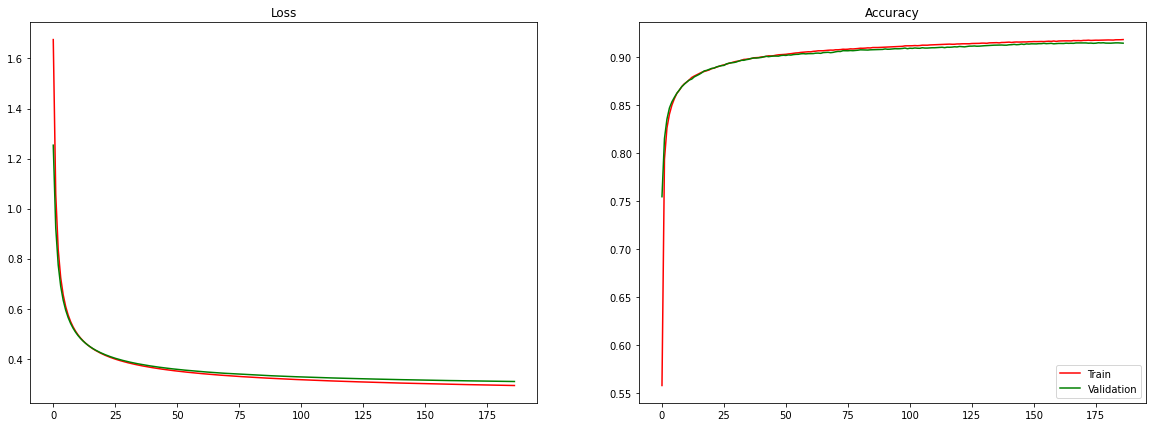

In [41]:
fig, (loss_ax, acc_ax) = plt.subplots(1, 2, figsize=(20,7))

loss_ax.set_title('Loss')
loss_ax.plot(mnist_baseline_model_train.history['loss'], '-r', label='Train')
loss_ax.plot(mnist_baseline_model_train.history['val_loss'], '-g', label='Validation')

acc_ax.set_title('Accuracy')
acc_ax.plot(mnist_baseline_model_train.history['accuracy'], '-r', label='Train')
acc_ax.plot(mnist_baseline_model_train.history['val_accuracy'], '-g', label='Validation')

plt.legend(loc=4)
plt.show()

#### Multi-Layer Model

To create a network with hidden layers, we simply add additional [Dense](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dense) layers before the output layer:

##### 1 Hidden Layer

In [45]:
mnist_hidden_model = tf.keras.Sequential(name='mnist_hidden')
mnist_hidden_model.add(tf.keras.layers.Input(mnist_info.features['image'].shape))
mnist_hidden_model.add(tf.keras.layers.Dense(32, activation='tanh', name='hidden'))
mnist_hidden_model.add(tf.keras.layers.Flatten(name='flatten'))
mnist_hidden_model.add(tf.keras.layers.Dense(mnist_info.features['label'].num_classes, activation='softmax', name='output'))
mnist_hidden_model.compile(loss='sparse_categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])
mnist_hidden_model.summary()

Model: "mnist_hidden"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
hidden (Dense)               (None, 28, 28, 32)        64        
_________________________________________________________________
flatten (Flatten)            (None, 25088)             0         
_________________________________________________________________
output (Dense)               (None, 10)                250890    
Total params: 250,954
Trainable params: 250,954
Non-trainable params: 0
_________________________________________________________________


In [46]:
earlystop = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=10, verbose=1)
checkpoint = tf.keras.callbacks.ModelCheckpoint('mnist_hidden_best.h5', monitor='val_accuracy', verbose=1, save_best_only=True)

mnist_hidden_model_train = mnist_hidden_model.fit(mnist_train_x, mnist_train_y, validation_split=0.2, callbacks=[earlystop,checkpoint], epochs=10000, batch_size=256)

Epoch 1/10000
187/188 [============================>.] - ETA: 0s - loss: 1.2566 - accuracy: 0.7655
Epoch 00001: val_accuracy improved from -inf to 0.84575, saving model to mnist_hidden_best.h5
188/188 [==============================] - 14s 72ms/step - loss: 1.2554 - accuracy: 0.7657 - val_loss: 0.7209 - val_accuracy: 0.8457
Epoch 2/10000
187/188 [============================>.] - ETA: 0s - loss: 0.5838 - accuracy: 0.8603
Epoch 00002: val_accuracy improved from 0.84575 to 0.87092, saving model to mnist_hidden_best.h5
188/188 [==============================] - 13s 72ms/step - loss: 0.5837 - accuracy: 0.8603 - val_loss: 0.5020 - val_accuracy: 0.8709
Epoch 3/10000
187/188 [============================>.] - ETA: 0s - loss: 0.4594 - accuracy: 0.8782
Epoch 00003: val_accuracy improved from 0.87092 to 0.88408, saving model to mnist_hidden_best.h5
188/188 [==============================] - 13s 71ms/step - loss: 0.4591 - accuracy: 0.8783 - val_loss: 0.4322 - val_accuracy: 0.8841
Epoch 4/10000
18

In [47]:
mnist_hidden_model.load_weights('mnist_hidden_best.h5')
loss, acc = mnist_hidden_model.evaluate(mnist_test_x, mnist_test_y)
print('Accuracy: {}'.format(acc))

313/313 [==============================] - 1s 4ms/step - loss: 0.2745 - accuracy: 0.9221
Accuracy: 0.9221000075340271


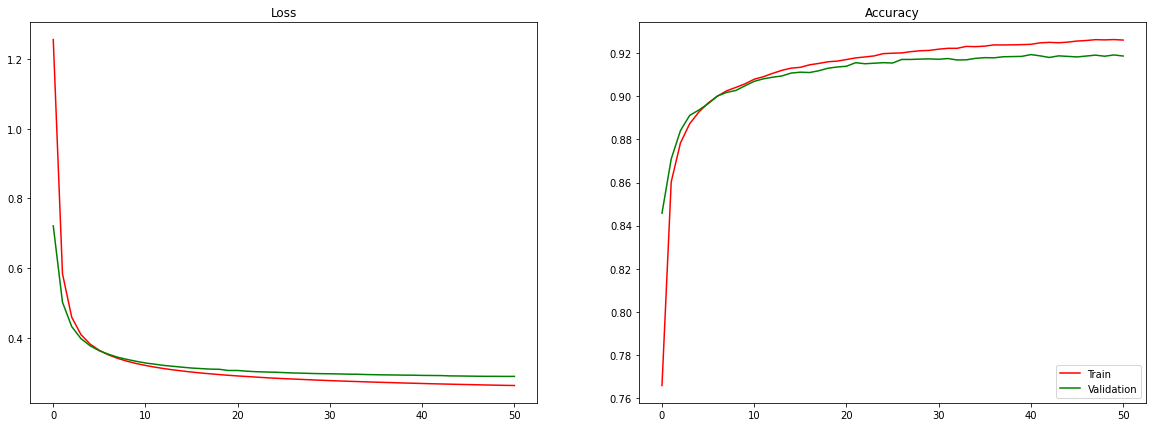

In [48]:
fig, (loss_ax, acc_ax) = plt.subplots(1, 2, figsize=(20,7))

loss_ax.set_title('Loss')
loss_ax.plot(mnist_hidden_model_train.history['loss'], '-r', label='Train')
loss_ax.plot(mnist_hidden_model_train.history['val_loss'], '-g', label='Validation')

acc_ax.set_title('Accuracy')
acc_ax.plot(mnist_hidden_model_train.history['accuracy'], '-r', label='Train')
acc_ax.plot(mnist_hidden_model_train.history['val_accuracy'], '-g', label='Validation')

plt.legend(loc=4)
plt.show()

##### 2 Hidden Layers



In [49]:
mnist_hidden2_model = tf.keras.Sequential(name='mnist_hidden2')
mnist_hidden2_model.add(tf.keras.layers.Input(mnist_info.features['image'].shape))
mnist_hidden2_model.add(tf.keras.layers.Dense(32, activation='tanh', name='hidden1'))
mnist_hidden2_model.add(tf.keras.layers.Dense(32, activation='tanh', name='hidden2'))
mnist_hidden2_model.add(tf.keras.layers.Flatten(name='flatten'))
mnist_hidden2_model.add(tf.keras.layers.Dense(mnist_info.features['label'].num_classes, activation='softmax', name='output'))
mnist_hidden2_model.compile(loss='sparse_categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])
mnist_hidden2_model.summary()

Model: "mnist_hidden2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
hidden1 (Dense)              (None, 28, 28, 32)        64        
_________________________________________________________________
hidden2 (Dense)              (None, 28, 28, 32)        1056      
_________________________________________________________________
flatten (Flatten)            (None, 25088)             0         
_________________________________________________________________
output (Dense)               (None, 10)                250890    
Total params: 252,010
Trainable params: 252,010
Non-trainable params: 0
_________________________________________________________________


In [50]:
earlystop = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=10, verbose=1)
checkpoint = tf.keras.callbacks.ModelCheckpoint('mnist_hidden2_best.h5', monitor='val_accuracy', verbose=1, save_best_only=True)

mnist_hidden2_model_train = mnist_hidden2_model.fit(mnist_train_x, mnist_train_y, validation_split=0.2, callbacks=[earlystop,checkpoint], epochs=10000, batch_size=256)

Epoch 1/10000
188/188 [==============================] - ETA: 0s - loss: 1.1174 - accuracy: 0.7709
Epoch 00001: val_accuracy improved from -inf to 0.86408, saving model to mnist_hidden2_best.h5
188/188 [==============================] - 26s 137ms/step - loss: 1.1174 - accuracy: 0.7709 - val_loss: 0.5342 - val_accuracy: 0.8641
Epoch 2/10000
188/188 [==============================] - ETA: 0s - loss: 0.4486 - accuracy: 0.8765
Epoch 00002: val_accuracy improved from 0.86408 to 0.88642, saving model to mnist_hidden2_best.h5
188/188 [==============================] - 26s 137ms/step - loss: 0.4486 - accuracy: 0.8765 - val_loss: 0.4025 - val_accuracy: 0.8864
Epoch 3/10000
188/188 [==============================] - ETA: 0s - loss: 0.3764 - accuracy: 0.8917
Epoch 00003: val_accuracy improved from 0.88642 to 0.89792, saving model to mnist_hidden2_best.h5
188/188 [==============================] - 26s 136ms/step - loss: 0.3764 - accuracy: 0.8917 - val_loss: 0.3631 - val_accuracy: 0.8979
Epoch 4/10

In [0]:
mnist_hidden2_model.load_weights('mnist_hidden2_best.h5')
loss, acc = mnist_hidden2_model.evaluate(mnist_test_x, mnist_test_y)
print('Accuracy: {}'.format(acc))

313/313 [==============================] - 2s 7ms/step - loss: 0.2641 - accuracy: 0.9257
Accuracy: 0.9257000088691711


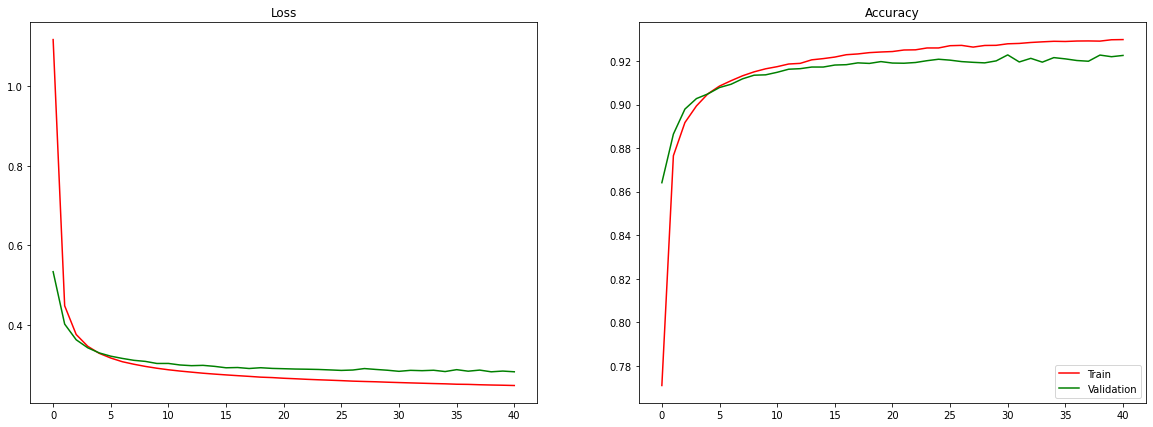

In [52]:
fig, (loss_ax, acc_ax) = plt.subplots(1, 2, figsize=(20,7))

loss_ax.set_title('Loss')
loss_ax.plot(mnist_hidden2_model_train.history['loss'], '-r', label='Train')
loss_ax.plot(mnist_hidden2_model_train.history['val_loss'], '-g', label='Validation')

acc_ax.set_title('Accuracy')
acc_ax.plot(mnist_hidden2_model_train.history['accuracy'], '-r', label='Train')
acc_ax.plot(mnist_hidden2_model_train.history['val_accuracy'], '-g', label='Validation')

plt.legend(loc=4)
plt.show()

##### 3 Hidden Layers

In [0]:
mnist_hidden3_model = tf.keras.Sequential(name='mnist_hidden3')
mnist_hidden3_model.add(tf.keras.layers.Input(mnist_info.features['image'].shape))
mnist_hidden3_model.add(tf.keras.layers.Dense(32, activation='tanh', name='hidden1'))
mnist_hidden3_model.add(tf.keras.layers.Dense(32, activation='tanh', name='hidden2'))
mnist_hidden3_model.add(tf.keras.layers.Dense(32, activation='tanh', name='hidden3'))
mnist_hidden3_model.add(tf.keras.layers.Flatten(name='flatten'))
mnist_hidden3_model.add(tf.keras.layers.Dense(mnist_info.features['label'].num_classes, activation='softmax', name='output'))
mnist_hidden3_model.compile(loss='sparse_categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])
mnist_hidden3_model.summary()

Model: "mnist_hidden3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
hidden1 (Dense)              (None, 28, 28, 32)        64        
_________________________________________________________________
hidden2 (Dense)              (None, 28, 28, 32)        1056      
_________________________________________________________________
hidden3 (Dense)              (None, 28, 28, 32)        1056      
_________________________________________________________________
flatten (Flatten)            (None, 25088)             0         
_________________________________________________________________
output (Dense)               (None, 10)                250890    
Total params: 253,066
Trainable params: 253,066
Non-trainable params: 0
_________________________________________________________________


In [0]:
earlystop = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=10, verbose=1)
checkpoint = tf.keras.callbacks.ModelCheckpoint('mnist_hidden3_best.h5', monitor='val_accuracy', verbose=1, save_best_only=True)

mnist_hidden3_model_train = mnist_hidden3_model.fit(mnist_train_x, mnist_train_y, validation_split=0.2, callbacks=[earlystop,checkpoint], epochs=10000, batch_size=256)

Epoch 1/10000
188/188 [==============================] - ETA: 0s - loss: 1.0047 - accuracy: 0.7785
Epoch 00001: val_accuracy improved from -inf to 0.87358, saving model to mnist_hidden3_best.h5
188/188 [==============================] - 33s 175ms/step - loss: 1.0047 - accuracy: 0.7785 - val_loss: 0.4531 - val_accuracy: 0.8736
Epoch 2/10000
188/188 [==============================] - ETA: 0s - loss: 0.3947 - accuracy: 0.8868
Epoch 00002: val_accuracy improved from 0.87358 to 0.89625, saving model to mnist_hidden3_best.h5
188/188 [==============================] - 33s 175ms/step - loss: 0.3947 - accuracy: 0.8868 - val_loss: 0.3645 - val_accuracy: 0.8963
Epoch 3/10000
188/188 [==============================] - ETA: 0s - loss: 0.3429 - accuracy: 0.9005
Epoch 00003: val_accuracy improved from 0.89625 to 0.90400, saving model to mnist_hidden3_best.h5
188/188 [==============================] - 33s 174ms/step - loss: 0.3429 - accuracy: 0.9005 - val_loss: 0.3366 - val_accuracy: 0.9040
Epoch 4/10

In [0]:
mnist_hidden3_model.load_weights('mnist_hidden3_best.h5')
loss, acc = mnist_hidden3_model.evaluate(mnist_test_x, mnist_test_y)
print('Accuracy: {}'.format(acc))

313/313 [==============================] - 3s 10ms/step - loss: 0.2641 - accuracy: 0.9252
Accuracy: 0.9251999855041504


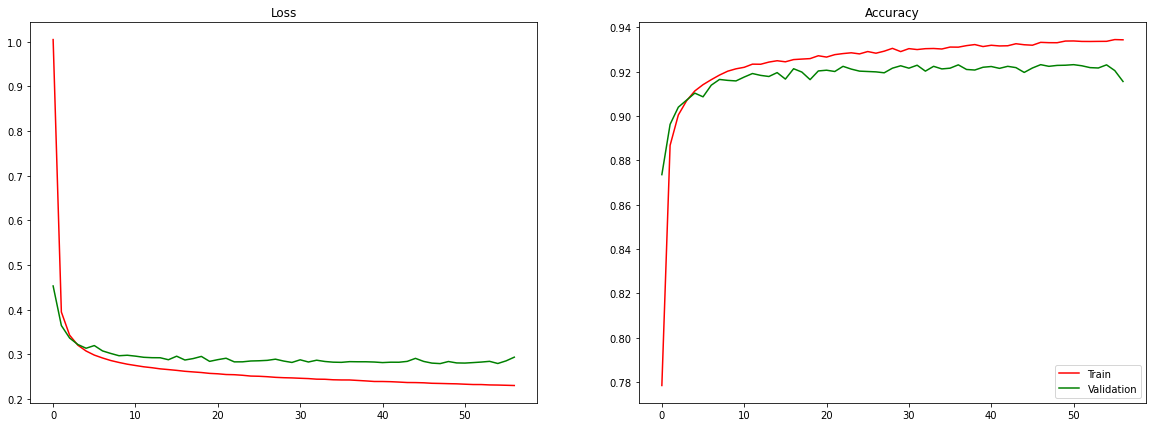

In [53]:
fig, (loss_ax, acc_ax) = plt.subplots(1, 2, figsize=(20,7))

loss_ax.set_title('Loss')
loss_ax.plot(mnist_hidden3_model_train.history['loss'], '-r', label='Train')
loss_ax.plot(mnist_hidden3_model_train.history['val_loss'], '-g', label='Validation')

acc_ax.set_title('Accuracy')
acc_ax.plot(mnist_hidden3_model_train.history['accuracy'], '-r', label='Train')
acc_ax.plot(mnist_hidden3_model_train.history['val_accuracy'], '-g', label='Validation')

plt.legend(loc=4)
plt.show()

#### Regularization


##### **Weight Regularization**
The Occam's Razor principle states: given two explanations for something, the explanation most likely to be correct is the "simplest" one, the one that makes the least amount of assumptions. This also applies to the models learned by neural networks: given some training data and a network architecture, there are multiple sets of weights values (multiple models) that could explain the data, and simpler models are less likely to overfit than complex ones.

A "simple model" in this context is a model where the distribution of parameter values has less entropy (or a model with fewer parameters altogether, as we saw in the section above). Thus a common way to mitigate overfitting is to put constraints on the complexity of a network by forcing its weights only to take small values, which makes the distribution of weight values more "regular". This is called "weight regularization", and it is done by adding to the loss function of the network a cost associated with having large weights. This cost comes in two flavors:

*  **L1 regularization**, where the cost added is proportional to the absolute value of the weights coefficients (i.e. to what is called the "L1 norm" of the weights).
*   **L2 regularization**, where the cost added is proportional to the square of the value of the weights coefficients (i.e. to what is called the squared "L2 norm" of the weights). L2 regularization is also called weight decay in the context of neural networks. 

L1 regularization pushes weights towards exactly zero encouraging a sparse model. L2 regularization will penalize the weights parameters without making them sparse since the penalty goes to zero for small weights, one reason why L2 is more common.


Let's then proceed in making a L2 regularization.

In [16]:
mnist_hidden_kr_model = tf.keras.Sequential(name='mnist_hidden')
mnist_hidden_kr_model.add(tf.keras.layers.Input(mnist_info.features['image'].shape))
mnist_hidden_kr_model.add(tf.keras.layers.Dense(32, activation='tanh', kernel_regularizer=tf.keras.regularizers.l2(0.01), name='hidden'))
mnist_hidden_kr_model.add(tf.keras.layers.Flatten(name='flatten'))
mnist_hidden_kr_model.add(tf.keras.layers.Dense(mnist_info.features['label'].num_classes, activation='softmax', name='output'))
mnist_hidden_kr_model.compile(loss='sparse_categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])
mnist_hidden_kr_model.summary()

Model: "mnist_hidden"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
hidden (Dense)               (None, 28, 28, 32)        64        
_________________________________________________________________
flatten (Flatten)            (None, 25088)             0         
_________________________________________________________________
output (Dense)               (None, 10)                250890    
Total params: 250,954
Trainable params: 250,954
Non-trainable params: 0
_________________________________________________________________


In [17]:
earlystop = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=10, verbose=1)
checkpoint = tf.keras.callbacks.ModelCheckpoint('mnist_hidden_kr__best.h5', monitor='val_accuracy', verbose=1, save_best_only=True)

mnist_hidden_kr_model_train = mnist_hidden_kr_model.fit(mnist_train_x, mnist_train_y, validation_split=0.2, callbacks=[earlystop,checkpoint], epochs=10000, batch_size=256)

Epoch 1/10000
187/188 [============================>.] - ETA: 0s - loss: 1.3540 - accuracy: 0.7558
Epoch 00001: val_accuracy improved from -inf to 0.83742, saving model to mnist_hidden_kr__best.h5
188/188 [==============================] - 11s 61ms/step - loss: 1.3524 - accuracy: 0.7560 - val_loss: 0.8044 - val_accuracy: 0.8374
Epoch 2/10000
187/188 [============================>.] - ETA: 0s - loss: 0.6581 - accuracy: 0.8550
Epoch 00002: val_accuracy improved from 0.83742 to 0.86658, saving model to mnist_hidden_kr__best.h5
188/188 [==============================] - 11s 61ms/step - loss: 0.6581 - accuracy: 0.8549 - val_loss: 0.5729 - val_accuracy: 0.8666
Epoch 3/10000
187/188 [============================>.] - ETA: 0s - loss: 0.5305 - accuracy: 0.8749
Epoch 00003: val_accuracy improved from 0.86658 to 0.87958, saving model to mnist_hidden_kr__best.h5
188/188 [==============================] - 11s 61ms/step - loss: 0.5304 - accuracy: 0.8749 - val_loss: 0.5041 - val_accuracy: 0.8796
Epoc

In [19]:
mnist_hidden_kr_model.load_weights('mnist_hidden_kr__best.h5')
loss, acc = mnist_hidden_kr_model.evaluate(mnist_test_x, mnist_test_y)
print('Accuracy: {}'.format(acc))

313/313 [==============================] - 1s 4ms/step - loss: 0.3226 - accuracy: 0.9210
Accuracy: 0.9210000038146973


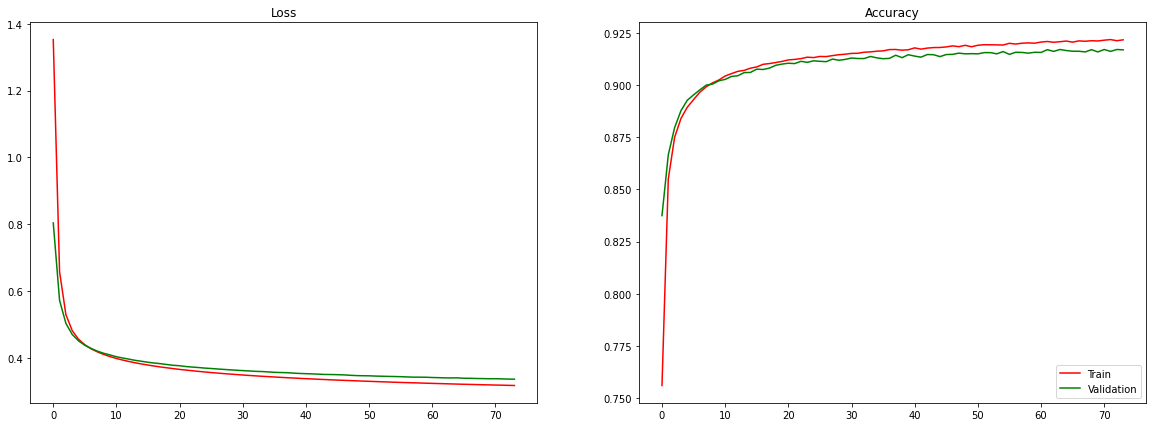

In [54]:
fig, (loss_ax, acc_ax) = plt.subplots(1, 2, figsize=(20,7))

loss_ax.set_title('Loss')
loss_ax.plot(mnist_hidden_kr_model_train.history['loss'], '-r', label='Train')
loss_ax.plot(mnist_hidden_kr_model_train.history['val_loss'], '-g', label='Validation')

acc_ax.set_title('Accuracy')
acc_ax.plot(mnist_hidden_kr_model_train.history['accuracy'], '-r', label='Train')
acc_ax.plot(mnist_hidden_kr_model_train.history['val_accuracy'], '-g', label='Validation')

plt.legend(loc=4)
plt.show()

##### Dropout

In this scenario, instead of applying regularization to the weights, we will use a different approach to regularization, namely, dropout. The idea behind dropout is to disable a percentage of randomly selected neurons during each step of the training phase, in order to avoid overfitting. In [Keras](https://www.tensorflow.org/api_docs/python/tf/keras), we can apply dropout directly to some layers by defining the corresponding parameters, or by using the [Dropout](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dropout) layer and stating the percentage of neurons to disable.

In [21]:
mnist_hidden_do_model = tf.keras.Sequential(name='mnist_hidden_do')
mnist_hidden_do_model.add(tf.keras.layers.Input(mnist_info.features['image'].shape))
mnist_hidden_do_model.add(tf.keras.layers.Dense(32, activation='tanh', name='hidden'))
mnist_hidden_do_model.add(tf.keras.layers.Dropout(0.5, name='dropout'))
mnist_hidden_do_model.add(tf.keras.layers.Flatten(name='flatten'))
mnist_hidden_do_model.add(tf.keras.layers.Dense(mnist_info.features['label'].num_classes, activation='softmax', name='output'))
mnist_hidden_do_model.compile(loss='sparse_categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])
mnist_hidden_do_model.summary()

Model: "mnist_hidden_do"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
hidden (Dense)               (None, 28, 28, 32)        64        
_________________________________________________________________
dropout (Dropout)            (None, 28, 28, 32)        0         
_________________________________________________________________
flatten (Flatten)            (None, 25088)             0         
_________________________________________________________________
output (Dense)               (None, 10)                250890    
Total params: 250,954
Trainable params: 250,954
Non-trainable params: 0
_________________________________________________________________


In [22]:
earlystop = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=10, verbose=1)
checkpoint = tf.keras.callbacks.ModelCheckpoint('mnist_hidden_do__best.h5', monitor='val_accuracy', verbose=1, save_best_only=True)

mnist_hidden_do_model_train = mnist_hidden_do_model.fit(mnist_train_x, mnist_train_y, validation_split=0.2, callbacks=[earlystop,checkpoint], epochs=10000, batch_size=256)

Epoch 1/10000
188/188 [==============================] - ETA: 0s - loss: 1.3777 - accuracy: 0.7192
Epoch 00001: val_accuracy improved from -inf to 0.83275, saving model to mnist_hidden_do__best.h5
188/188 [==============================] - 23s 123ms/step - loss: 1.3777 - accuracy: 0.7192 - val_loss: 0.7847 - val_accuracy: 0.8328
Epoch 2/10000
188/188 [==============================] - ETA: 0s - loss: 0.6285 - accuracy: 0.8486
Epoch 00002: val_accuracy improved from 0.83275 to 0.86725, saving model to mnist_hidden_do__best.h5
188/188 [==============================] - 23s 123ms/step - loss: 0.6285 - accuracy: 0.8486 - val_loss: 0.5225 - val_accuracy: 0.8673
Epoch 3/10000
188/188 [==============================] - ETA: 0s - loss: 0.4830 - accuracy: 0.8709
Epoch 00003: val_accuracy improved from 0.86725 to 0.88083, saving model to mnist_hidden_do__best.h5
188/188 [==============================] - 23s 121ms/step - loss: 0.4830 - accuracy: 0.8709 - val_loss: 0.4429 - val_accuracy: 0.8808
E

In [23]:
mnist_hidden_do_model.load_weights('mnist_hidden_do__best.h5')
loss, acc = mnist_hidden_do_model.evaluate(mnist_test_x, mnist_test_y)
print('Accuracy: {}'.format(acc))

313/313 [==============================] - 1s 4ms/step - loss: 0.2658 - accuracy: 0.9253
Accuracy: 0.9253000020980835


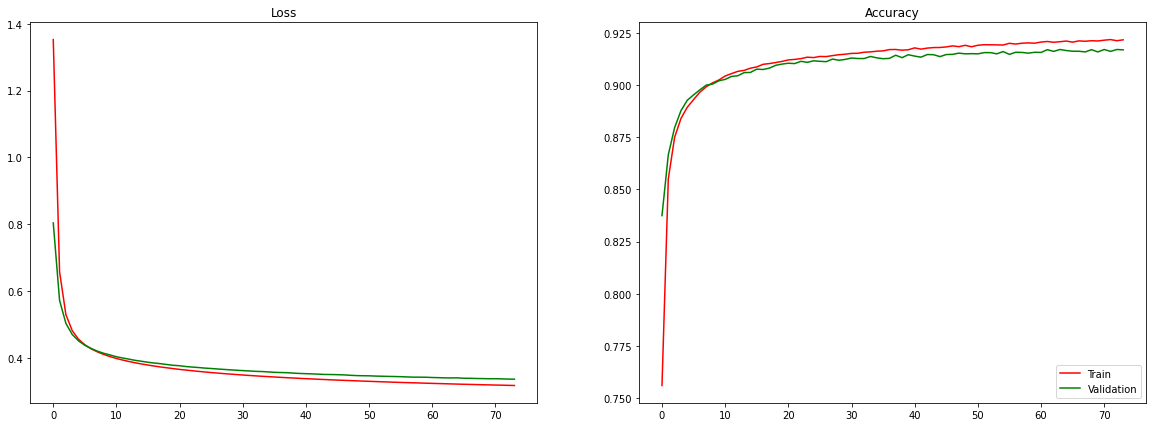

In [56]:
fig, (loss_ax, acc_ax) = plt.subplots(1, 2, figsize=(20,7))

loss_ax.set_title('Loss')
loss_ax.plot(mnist_hidden_kr_model_train.history['loss'], '-r', label='Train')
loss_ax.plot(mnist_hidden_kr_model_train.history['val_loss'], '-g', label='Validation')

acc_ax.set_title('Accuracy')
acc_ax.plot(mnist_hidden_kr_model_train.history['accuracy'], '-r', label='Train')
acc_ax.plot(mnist_hidden_kr_model_train.history['val_accuracy'], '-g', label='Validation')

plt.legend(loc=4)
plt.show()

##### Combined L2 + dropout

In [35]:
mnist_hidden_dol2_model = tf.keras.Sequential(name='mnist_dol2_hidden')
mnist_hidden_dol2_model.add(tf.keras.layers.Input(mnist_info.features['image'].shape))
mnist_hidden_dol2_model.add(tf.keras.layers.Dense(32, activation='tanh', kernel_regularizer=tf.keras.regularizers.l2(0.01), name='hidden'))
mnist_hidden_dol2_model.add(tf.keras.layers.Dropout(0.5, name='dropout'))
mnist_hidden_dol2_model.add(tf.keras.layers.Flatten(name='flatten'))
mnist_hidden_dol2_model.add(tf.keras.layers.Dense(mnist_info.features['label'].num_classes, activation='softmax', name='output'))
mnist_hidden_dol2_model.compile(loss='sparse_categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])
mnist_hidden_dol2_model.summary()

Model: "mnist_dol2_hidden"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
hidden (Dense)               (None, 28, 28, 32)        64        
_________________________________________________________________
dropout (Dropout)            (None, 28, 28, 32)        0         
_________________________________________________________________
flatten (Flatten)            (None, 25088)             0         
_________________________________________________________________
output (Dense)               (None, 10)                250890    
Total params: 250,954
Trainable params: 250,954
Non-trainable params: 0
_________________________________________________________________


In [36]:
earlystop = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=10, verbose=1)
checkpoint = tf.keras.callbacks.ModelCheckpoint('mnist_hidden_dol2_best.h5', monitor='val_accuracy', verbose=1, save_best_only=True)

mnist_hidden_dol2_model_train = mnist_hidden_dol2_model.fit(mnist_train_x, mnist_train_y, validation_split=0.2, callbacks=[earlystop,checkpoint], epochs=10000, batch_size=256)

Epoch 1/10000
188/188 [==============================] - ETA: 0s - loss: 1.2997 - accuracy: 0.7371
Epoch 00001: val_accuracy improved from -inf to 0.84283, saving model to mnist_hidden_dol2_best.h5
188/188 [==============================] - 26s 139ms/step - loss: 1.2997 - accuracy: 0.7371 - val_loss: 0.7723 - val_accuracy: 0.8428
Epoch 2/10000
188/188 [==============================] - ETA: 0s - loss: 0.6492 - accuracy: 0.8530
Epoch 00002: val_accuracy improved from 0.84283 to 0.86867, saving model to mnist_hidden_dol2_best.h5
188/188 [==============================] - 26s 137ms/step - loss: 0.6492 - accuracy: 0.8530 - val_loss: 0.5647 - val_accuracy: 0.8687
Epoch 3/10000
188/188 [==============================] - ETA: 0s - loss: 0.5329 - accuracy: 0.8723
Epoch 00003: val_accuracy improved from 0.86867 to 0.88042, saving model to mnist_hidden_dol2_best.h5
188/188 [==============================] - 26s 136ms/step - loss: 0.5329 - accuracy: 0.8723 - val_loss: 0.5002 - val_accuracy: 0.880

In [37]:
mnist_hidden_dol2_model.load_weights('mnist_dol2_best.h5')
loss, acc = mnist_hidden_dol2_model.evaluate(mnist_test_x, mnist_test_y)
print('Accuracy: {}'.format(acc))

313/313 [==============================] - 1s 4ms/step - loss: 0.3177 - accuracy: 0.9207
Accuracy: 0.9207000136375427


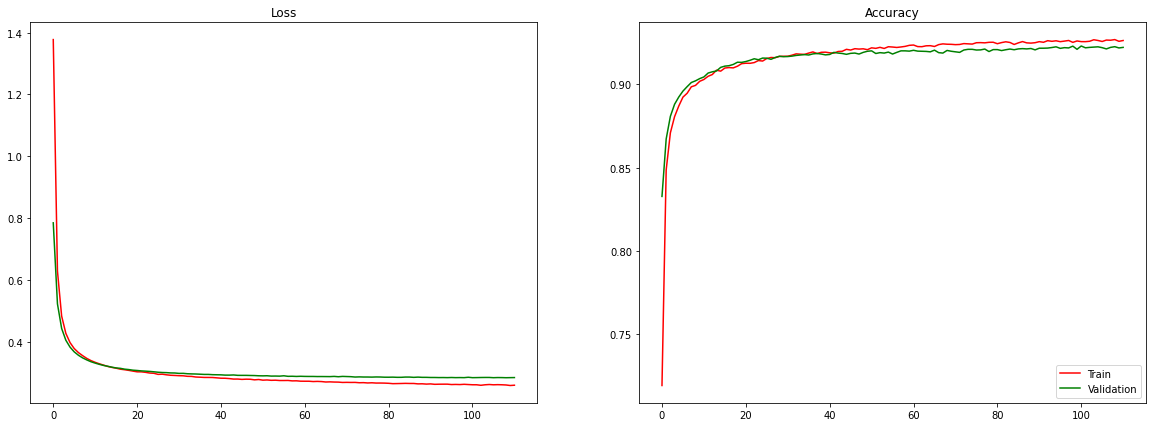

In [57]:
fig, (loss_ax, acc_ax) = plt.subplots(1, 2, figsize=(20,7))

loss_ax.set_title('Loss')
loss_ax.plot(mnist_hidden_do_model_train.history['loss'], '-r', label='Train')
loss_ax.plot(mnist_hidden_do_model_train.history['val_loss'], '-g', label='Validation')

acc_ax.set_title('Accuracy')
acc_ax.plot(mnist_hidden_do_model_train.history['accuracy'], '-r', label='Train')
acc_ax.plot(mnist_hidden_do_model_train.history['val_accuracy'], '-g', label='Validation')

plt.legend(loc=4)
plt.show()

## Convolutional Neural Networks

Convolutional layers capture patterns corresponding to relevant features independently of where they occur in the input. To do so, they slide a window over the input and apply the convolution operation with a set of kernels or filters that represent the features. Although it is not their only field of application, convolutional neural networks are mainly praised for their performance on image processing tasks. 

### Models

Now, let's create and train some networks to approach the problem posed by the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset.

#### Baseline

To create our CNN, instead of feeding the flatenned output directly to the output layer, we will first pass it through a convolutional layer followed by a max pooling operation. Since, we are dealing with 2D data, we will use the [Conv2D](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv2D) and [MaxPool2D](https://www.tensorflow.org/api_docs/python/tf/keras/layers/MaxPool2D) layers. 

In the convolutional layer, the *filters* parameter defines the number of kernels or filters used in the layer. The *kernel_size* parameter defines the size of the kernels. If only one number is provided, the kernel is assumed to be square. The stride values default to one, but can be changed using the *strides* parameter. Also, we can use same padding, by setting the *padding* parameter to 'same'.

For the pooling operation, we define the size of the pooling window using the *pool_size* parameter. Similarly to the *kernel_size* parameter of the convolutional layer, if only one number is provided, the window is assumed to be square. Additionally, the *strides* parameter defaults to the size of the pooling window. That is, there is no overlap.

In [0]:
mnist_conv_model = tf.keras.Sequential(name='mnist_cnn')
mnist_conv_model.add(tf.keras.layers.Input(mnist_info.features['image'].shape))
mnist_conv_model.add(tf.keras.layers.Conv2D(filters=16, kernel_size=4, activation='relu', padding='same', name='convolution'))
mnist_conv_model.add(tf.keras.layers.MaxPool2D(pool_size=2, name='pooling'))
mnist_conv_model.add(tf.keras.layers.Flatten(name='flatten'))
mnist_conv_model.add(tf.keras.layers.Dense(mnist_info.features['label'].num_classes, activation='softmax', name='output'))
mnist_conv_model.compile(loss='sparse_categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])
mnist_conv_model.summary()

Model: "mnist_cnn"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
convolution (Conv2D)         (None, 28, 28, 16)        272       
_________________________________________________________________
pooling (MaxPooling2D)       (None, 14, 14, 16)        0         
_________________________________________________________________
flatten (Flatten)            (None, 3136)              0         
_________________________________________________________________
output (Dense)               (None, 10)                31370     
Total params: 31,642
Trainable params: 31,642
Non-trainable params: 0
_________________________________________________________________


Let's train the model using the same approach as before:

In [0]:
earlystop = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=10, verbose=1)
checkpoint = tf.keras.callbacks.ModelCheckpoint('mnist_conv_best.h5', monitor='val_accuracy', verbose=1, save_best_only=True)

mnist_conv_model_train = mnist_conv_model.fit(mnist_train_x, mnist_train_y, validation_split=0.2, callbacks=[earlystop,checkpoint], epochs=10000, batch_size=256)

Epoch 1/10000
187/188 [============================>.] - ETA: 0s - loss: 1.5820 - accuracy: 0.6042
Epoch 00001: val_accuracy improved from -inf to 0.81442, saving model to mnist_conv_best.h5
188/188 [==============================] - 17s 91ms/step - loss: 1.5801 - accuracy: 0.6048 - val_loss: 0.7909 - val_accuracy: 0.8144
Epoch 2/10000
187/188 [============================>.] - ETA: 0s - loss: 0.5848 - accuracy: 0.8475
Epoch 00002: val_accuracy improved from 0.81442 to 0.87042, saving model to mnist_conv_best.h5
188/188 [==============================] - 17s 90ms/step - loss: 0.5843 - accuracy: 0.8475 - val_loss: 0.4752 - val_accuracy: 0.8704
Epoch 3/10000
187/188 [============================>.] - ETA: 0s - loss: 0.4354 - accuracy: 0.8767
Epoch 00003: val_accuracy improved from 0.87042 to 0.88367, saving model to mnist_conv_best.h5
188/188 [==============================] - 17s 90ms/step - loss: 0.4354 - accuracy: 0.8768 - val_loss: 0.4063 - val_accuracy: 0.8837
Epoch 4/10000
187/188 

And visualize the evolution:

NameError: ignored

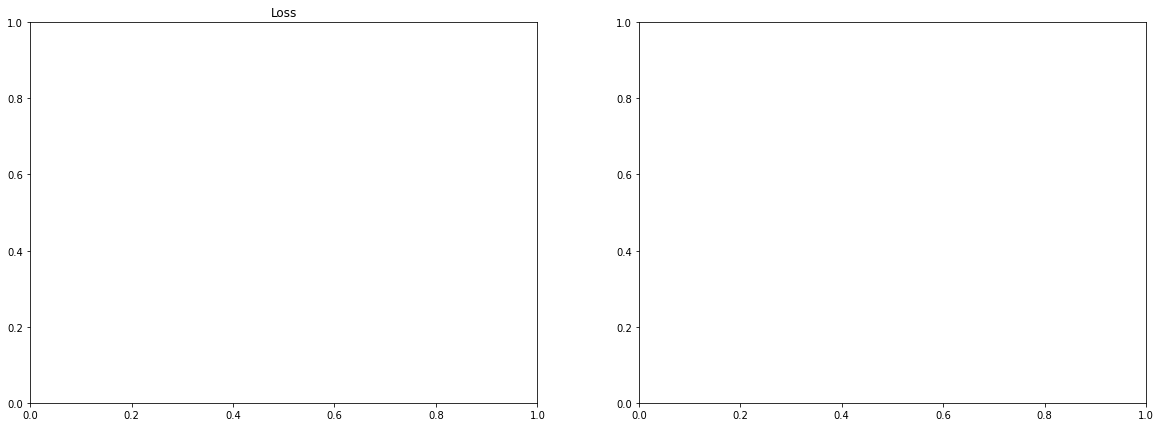

In [58]:
fig, (loss_ax, acc_ax) = plt.subplots(1, 2, figsize=(20,7))

loss_ax.set_title('Loss')
loss_ax.plot(mnist_conv_model_train.history['loss'], '-r', label='Train')
loss_ax.plot(mnist_conv_model_train.history['val_loss'], '-g', label='Validation')

acc_ax.set_title('Accuracy')
acc_ax.plot(mnist_conv_model_train.history['accuracy'], '-r', label='Train')
acc_ax.plot(mnist_conv_model_train.history['val_accuracy'], '-g', label='Validation')

plt.legend(loc=4)
plt.show()

*Finally*, we can evaluate the model on the test set, and verify that the performance is higher than without the convolutional layers.

In [0]:
mnist_conv_model.load_weights('mnist_conv_best.h5')
loss, acc = mnist_conv_model.evaluate(mnist_test_x, mnist_test_y)
print('Accuracy: {}'.format(acc))

313/313 [==============================] - 2s 6ms/step - loss: 0.0587 - accuracy: 0.9817
Accuracy: 0.9817000031471252


#### Hidden Layers


We will vary the number of hidden layers in order to see if the performance on the model is increased. We will do this by adding some more convolutional layers to the baseline model:

##### 2 Hidden Layers

In [0]:
mnist_2conv_model = tf.keras.Sequential(name='mnist_2cnn')
mnist_2conv_model.add(tf.keras.layers.Input(mnist_info.features['image'].shape))
mnist_2conv_model.add(tf.keras.layers.Conv2D(filters=16, kernel_size=4, activation='relu', padding='same', name='convolution'))
mnist_2conv_model.add(tf.keras.layers.MaxPool2D(pool_size=2, name='pooling'))
mnist_2conv_model.add(tf.keras.layers.Conv2D(filters=16, kernel_size=4, activation='relu', padding='same', name='convolution2'))
mnist_2conv_model.add(tf.keras.layers.MaxPool2D(pool_size=2, name='pooling2'))
mnist_2conv_model.add(tf.keras.layers.Flatten(name='flatten'))
mnist_2conv_model.add(tf.keras.layers.Dense(mnist_info.features['label'].num_classes, activation='softmax', name='output'))
mnist_2conv_model.compile(loss='sparse_categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])
mnist_2conv_model.summary()

Model: "mnist_2cnn"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
convolution (Conv2D)         (None, 28, 28, 16)        272       
_________________________________________________________________
pooling (MaxPooling2D)       (None, 14, 14, 16)        0         
_________________________________________________________________
convolution2 (Conv2D)        (None, 14, 14, 16)        4112      
_________________________________________________________________
pooling2 (MaxPooling2D)      (None, 7, 7, 16)          0         
_________________________________________________________________
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
output (Dense)               (None, 10)                7850      
Total params: 12,234
Trainable params: 12,234
Non-trainable params: 0
____________________________________________________

In [0]:
earlystop = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=10, verbose=1)
checkpoint = tf.keras.callbacks.ModelCheckpoint('mnist_2conv_best.h5', monitor='val_accuracy', verbose=1, save_best_only=True)

mnist_2conv_model_train = mnist_2conv_model.fit(mnist_train_x, mnist_train_y, validation_split=0.2, callbacks=[earlystop,checkpoint], epochs=10000, batch_size=256)

Epoch 1/10000
188/188 [==============================] - ETA: 0s - loss: 2.0604 - accuracy: 0.4080
Epoch 00001: val_accuracy improved from -inf to 0.69150, saving model to mnist_2conv_best.h5
188/188 [==============================] - 28s 150ms/step - loss: 2.0604 - accuracy: 0.4080 - val_loss: 1.3756 - val_accuracy: 0.6915
Epoch 2/10000
188/188 [==============================] - ETA: 0s - loss: 0.7256 - accuracy: 0.8135
Epoch 00002: val_accuracy improved from 0.69150 to 0.86733, saving model to mnist_2conv_best.h5
188/188 [==============================] - 28s 148ms/step - loss: 0.7256 - accuracy: 0.8135 - val_loss: 0.4708 - val_accuracy: 0.8673
Epoch 3/10000
188/188 [==============================] - ETA: 0s - loss: 0.3956 - accuracy: 0.8865
Epoch 00003: val_accuracy improved from 0.86733 to 0.90083, saving model to mnist_2conv_best.h5
188/188 [==============================] - 28s 148ms/step - loss: 0.3956 - accuracy: 0.8865 - val_loss: 0.3493 - val_accuracy: 0.9008
Epoch 4/10000
18

In [0]:
mnist_2conv_model.load_weights('mnist_2conv_best.h5')
loss, acc = mnist_2conv_model.evaluate(mnist_test_x, mnist_test_y)
print('Accuracy: {}'.format(acc))

313/313 [==============================] - 2s 7ms/step - loss: 0.0525 - accuracy: 0.9834
Accuracy: 0.9833999872207642


In [0]:
fig, (loss_ax, acc_ax) = plt.subplots(1, 2, figsize=(20,7))

loss_ax.set_title('Loss')
loss_ax.plot(mnist_2conv_model_train.history['loss'], '-r', label='Train')
loss_ax.plot(mnist_2conv_model_train.history['val_loss'], '-g', label='Validation')

acc_ax.set_title('Accuracy')
acc_ax.plot(mnist_2conv_model_train.history['accuracy'], '-r', label='Train')
acc_ax.plot(mnist_2conv_model_train.history['val_accuracy'], '-g', label='Validation')

plt.legend(loc=4)
plt.show()

##### 3 Hidden Layers

In [0]:
mnist_3conv_model = tf.keras.Sequential(name='mnist_3cnn')
mnist_3conv_model.add(tf.keras.layers.Input(mnist_info.features['image'].shape))
mnist_3conv_model.add(tf.keras.layers.Conv2D(filters=16, kernel_size=4, activation='relu', padding='same', name='convolution'))
mnist_3conv_model.add(tf.keras.layers.MaxPool2D(pool_size=2, name='pooling'))
mnist_3conv_model.add(tf.keras.layers.Conv2D(filters=16, kernel_size=4, activation='relu', padding='same', name='convolution2'))
mnist_3conv_model.add(tf.keras.layers.MaxPool2D(pool_size=2, name='pooling2'))
mnist_3conv_model.add(tf.keras.layers.Conv2D(filters=16, kernel_size=4, activation='relu', padding='same', name='convolution3'))
mnist_3conv_model.add(tf.keras.layers.MaxPool2D(pool_size=2, name='pooling3'))
mnist_3conv_model.add(tf.keras.layers.Flatten(name='flatten'))
mnist_3conv_model.add(tf.keras.layers.Dense(mnist_info.features['label'].num_classes, activation='softmax', name='output'))
mnist_3conv_model.compile(loss='sparse_categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])
mnist_3conv_model.summary()

Model: "mnist_3cnn"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
convolution (Conv2D)         (None, 28, 28, 16)        272       
_________________________________________________________________
pooling (MaxPooling2D)       (None, 14, 14, 16)        0         
_________________________________________________________________
convolution2 (Conv2D)        (None, 14, 14, 16)        4112      
_________________________________________________________________
pooling2 (MaxPooling2D)      (None, 7, 7, 16)          0         
_________________________________________________________________
convolution3 (Conv2D)        (None, 7, 7, 16)          4112      
_________________________________________________________________
pooling3 (MaxPooling2D)      (None, 3, 3, 16)          0         
_________________________________________________________________
flatten (Flatten)            (None, 144)               0

In [0]:
earlystop = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=10, verbose=1)
checkpoint = tf.keras.callbacks.ModelCheckpoint('mnist_3conv_best.h5', monitor='val_accuracy', verbose=1, save_best_only=True)

mnist_3conv_model_train = mnist_3conv_model.fit(mnist_train_x, mnist_train_y, validation_split=0.2, callbacks=[earlystop,checkpoint], epochs=10000, batch_size=256)

Epoch 1/10000
188/188 [==============================] - ETA: 0s - loss: 2.2548 - accuracy: 0.1564
Epoch 00001: val_accuracy improved from -inf to 0.28933, saving model to mnist_3conv_best.h5
188/188 [==============================] - 31s 167ms/step - loss: 2.2548 - accuracy: 0.1564 - val_loss: 2.1513 - val_accuracy: 0.2893
Epoch 2/10000
188/188 [==============================] - ETA: 0s - loss: 1.5277 - accuracy: 0.5924
Epoch 00002: val_accuracy improved from 0.28933 to 0.75683, saving model to mnist_3conv_best.h5
188/188 [==============================] - 31s 166ms/step - loss: 1.5277 - accuracy: 0.5924 - val_loss: 0.7861 - val_accuracy: 0.7568
Epoch 3/10000
188/188 [==============================] - ETA: 0s - loss: 0.5739 - accuracy: 0.8266
Epoch 00003: val_accuracy improved from 0.75683 to 0.84933, saving model to mnist_3conv_best.h5
188/188 [==============================] - 31s 166ms/step - loss: 0.5739 - accuracy: 0.8266 - val_loss: 0.4786 - val_accuracy: 0.8493
Epoch 4/10000
18

In [0]:
mnist_3conv_model.load_weights('mnist_3conv_best.h5')
loss, acc = mnist_3conv_model.evaluate(mnist_test_x, mnist_test_y)
print('Accuracy: {}'.format(acc))

313/313 [==============================] - 2s 8ms/step - loss: 0.0503 - accuracy: 0.9842
Accuracy: 0.9842000007629395


In [0]:
fig, (loss_ax, acc_ax) = plt.subplots(1, 2, figsize=(20,7))

loss_ax.set_title('Loss')
loss_ax.plot(mnist_3conv_model_train.history['loss'], '-r', label='Train')
loss_ax.plot(mnist_3conv_model_train.history['val_loss'], '-g', label='Validation')

acc_ax.set_title('Accuracy')
acc_ax.plot(mnist_3conv_model_train.history['accuracy'], '-r', label='Train')
acc_ax.plot(mnist_3conv_model_train.history['val_accuracy'], '-g', label='Validation')

plt.legend(loc=4)
plt.show()

##### 4 Hidden Layers

In [0]:
mnist_4conv_model = tf.keras.Sequential(name='mnist_4cnn')
mnist_4conv_model.add(tf.keras.layers.Input(mnist_info.features['image'].shape))
mnist_4conv_model.add(tf.keras.layers.Conv2D(filters=16, kernel_size=4, activation='relu', padding='same', name='convolution'))
mnist_4conv_model.add(tf.keras.layers.MaxPool2D(pool_size=2, name='pooling'))
mnist_4conv_model.add(tf.keras.layers.Conv2D(filters=16, kernel_size=4, activation='relu', padding='same', name='convolution2'))
mnist_4conv_model.add(tf.keras.layers.MaxPool2D(pool_size=2, name='pooling2'))
mnist_4conv_model.add(tf.keras.layers.Conv2D(filters=16, kernel_size=4, activation='relu', padding='same', name='convolution3'))
mnist_4conv_model.add(tf.keras.layers.MaxPool2D(pool_size=2, name='pooling3'))
mnist_4conv_model.add(tf.keras.layers.Conv2D(filters=16, kernel_size=4, activation='relu', padding='same', name='convolution4'))
mnist_4conv_model.add(tf.keras.layers.MaxPool2D(pool_size=2, name='pooling4'))
mnist_4conv_model.add(tf.keras.layers.Flatten(name='flatten'))
mnist_4conv_model.add(tf.keras.layers.Dense(mnist_info.features['label'].num_classes, activation='softmax', name='output'))
mnist_4conv_model.compile(loss='sparse_categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])
mnist_4conv_model.summary()

Model: "mnist_4cnn"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
convolution (Conv2D)         (None, 28, 28, 16)        272       
_________________________________________________________________
pooling (MaxPooling2D)       (None, 14, 14, 16)        0         
_________________________________________________________________
convolution2 (Conv2D)        (None, 14, 14, 16)        4112      
_________________________________________________________________
pooling2 (MaxPooling2D)      (None, 7, 7, 16)          0         
_________________________________________________________________
convolution3 (Conv2D)        (None, 7, 7, 16)          4112      
_________________________________________________________________
pooling3 (MaxPooling2D)      (None, 3, 3, 16)          0         
_________________________________________________________________
convolution4 (Conv2D)        (None, 3, 3, 16)          4

In [0]:
earlystop = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=10, verbose=1)
checkpoint = tf.keras.callbacks.ModelCheckpoint('mnist_4conv_best.h5', monitor='val_accuracy', verbose=1, save_best_only=True)

mnist_4conv_model_train = mnist_4conv_model.fit(mnist_train_x, mnist_train_y, validation_split=0.2, callbacks=[earlystop,checkpoint], epochs=10000, batch_size=256)

Epoch 1/10000
188/188 [==============================] - ETA: 0s - loss: 2.2857 - accuracy: 0.1653
Epoch 00001: val_accuracy improved from -inf to 0.19133, saving model to mnist_4conv_best.h5
188/188 [==============================] - 35s 184ms/step - loss: 2.2857 - accuracy: 0.1653 - val_loss: 2.2624 - val_accuracy: 0.1913
Epoch 2/10000
188/188 [==============================] - ETA: 0s - loss: 2.1822 - accuracy: 0.3062
Epoch 00002: val_accuracy improved from 0.19133 to 0.47433, saving model to mnist_4conv_best.h5
188/188 [==============================] - 34s 182ms/step - loss: 2.1822 - accuracy: 0.3062 - val_loss: 1.9817 - val_accuracy: 0.4743
Epoch 3/10000
188/188 [==============================] - ETA: 0s - loss: 1.3815 - accuracy: 0.6084
Epoch 00003: val_accuracy improved from 0.47433 to 0.62950, saving model to mnist_4conv_best.h5
188/188 [==============================] - 34s 180ms/step - loss: 1.3815 - accuracy: 0.6084 - val_loss: 1.1951 - val_accuracy: 0.6295
Epoch 4/10000
18

In [0]:
mnist_4conv_model.load_weights('mnist_4conv_best.h5')
loss, acc = mnist_4conv_model.evaluate(mnist_test_x, mnist_test_y)
print('Accuracy: {}'.format(acc))

313/313 [==============================] - 3s 10ms/step - loss: 0.0542 - accuracy: 0.9820
Accuracy: 0.9819999933242798


NameError: ignored

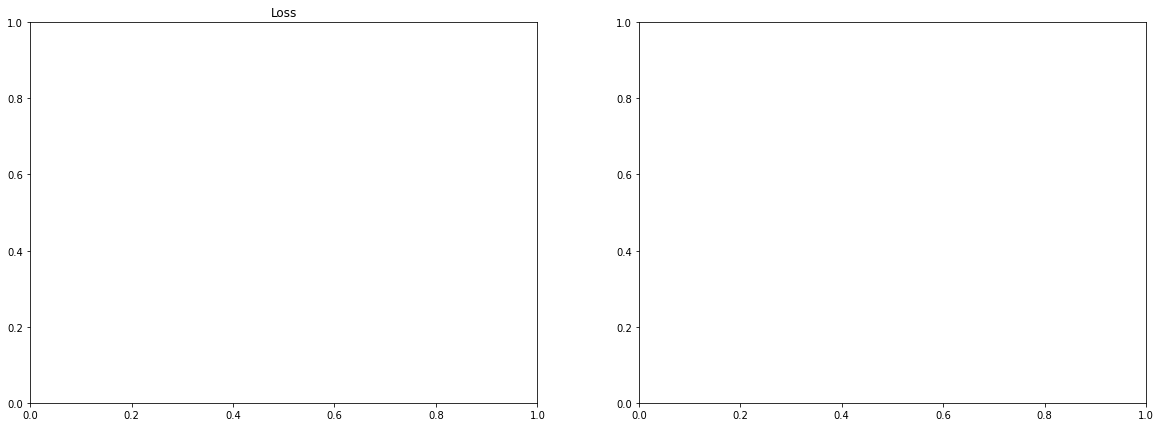

In [51]:
fig, (loss_ax, acc_ax) = plt.subplots(1, 2, figsize=(20,7))

loss_ax.set_title('Loss')
loss_ax.plot(mnist_4conv_model_train.history['loss'], '-r', label='Train')
loss_ax.plot(mnist_4conv_model_train.history['val_loss'], '-g', label='Validation')

acc_ax.set_title('Accuracy')
acc_ax.plot(mnist_4conv_model_train.history['accuracy'], '-r', label='Train')
acc_ax.plot(mnist_4conv_model_train.history['val_accuracy'], '-g', label='Validation')

plt.legend(loc=4)
plt.show()

#### Regularization


##### **Weight Regularization**
The Occam's Razor principle states: given two explanations for something, the explanation most likely to be correct is the "simplest" one, the one that makes the least amount of assumptions. This also applies to the models learned by neural networks: given some training data and a network architecture, there are multiple sets of weights values (multiple models) that could explain the data, and simpler models are less likely to overfit than complex ones.

A "simple model" in this context is a model where the distribution of parameter values has less entropy (or a model with fewer parameters altogether, as we saw in the section above). Thus a common way to mitigate overfitting is to put constraints on the complexity of a network by forcing its weights only to take small values, which makes the distribution of weight values more "regular". This is called "weight regularization", and it is done by adding to the loss function of the network a cost associated with having large weights. This cost comes in two flavors:

*  **L1 regularization**, where the cost added is proportional to the absolute value of the weights coefficients (i.e. to what is called the "L1 norm" of the weights).
*   **L2 regularization**, where the cost added is proportional to the square of the value of the weights coefficients (i.e. to what is called the squared "L2 norm" of the weights). L2 regularization is also called weight decay in the context of neural networks. 

L1 regularization pushes weights towards exactly zero encouraging a sparse model. L2 regularization will penalize the weights parameters without making them sparse since the penalty goes to zero for small weights, one reason why L2 is more common.


Let's then proceed in making a L2 regularization.

**kernel_regularizer:** Regularizer to apply a penalty on the layer's kernel


In [0]:
mnist_l2_model = tf.keras.Sequential(name='mnist_l2_cnn')
mnist_l2_model.add(tf.keras.layers.Input(mnist_info.features['image'].shape))
mnist_l2_model.add(tf.keras.layers.Conv2D(filters=16, kernel_size=4, activation='relu', padding='same', name='convolution', kernel_regularizer=tf.keras.regularizers.l2(0.01)))
mnist_l2_model.add(tf.keras.layers.MaxPool2D(pool_size=2, name='pooling'))
mnist_l2_model.add(tf.keras.layers.Flatten(name='flatten'))
mnist_l2_model.add(tf.keras.layers.Dense(mnist_info.features['label'].num_classes, activation='softmax', name='output'))
mnist_l2_model.compile(loss='sparse_categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])
mnist_l2_model.summary()

Model: "mnist_cnn"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
convolution (Conv2D)         (None, 28, 28, 16)        272       
_________________________________________________________________
pooling (MaxPooling2D)       (None, 14, 14, 16)        0         
_________________________________________________________________
flatten (Flatten)            (None, 3136)              0         
_________________________________________________________________
output (Dense)               (None, 10)                31370     
Total params: 31,642
Trainable params: 31,642
Non-trainable params: 0
_________________________________________________________________


In [0]:
earlystop = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=10, verbose=1)
checkpoint = tf.keras.callbacks.ModelCheckpoint('mnist_l2_best.h5', monitor='val_accuracy', verbose=1, save_best_only=True)

mnist_l2_model_train = mnist_l2_model.fit(mnist_train_x, mnist_train_y, validation_split=0.2, callbacks=[earlystop,checkpoint], epochs=10000, batch_size=256)

Epoch 1/10000
187/188 [============================>.] - ETA: 0s - loss: 1.9535 - accuracy: 0.4783
Epoch 00001: val_accuracy improved from -inf to 0.77767, saving model to mnist_l2_best.h5
188/188 [==============================] - 17s 91ms/step - loss: 1.9515 - accuracy: 0.4789 - val_loss: 1.1546 - val_accuracy: 0.7777
Epoch 2/10000
187/188 [============================>.] - ETA: 0s - loss: 0.7455 - accuracy: 0.8356
Epoch 00002: val_accuracy improved from 0.77767 to 0.86108, saving model to mnist_l2_best.h5
188/188 [==============================] - 17s 90ms/step - loss: 0.7449 - accuracy: 0.8358 - val_loss: 0.5627 - val_accuracy: 0.8611
Epoch 3/10000
187/188 [============================>.] - ETA: 0s - loss: 0.5087 - accuracy: 0.8745
Epoch 00003: val_accuracy improved from 0.86108 to 0.87917, saving model to mnist_l2_best.h5
188/188 [==============================] - 17s 90ms/step - loss: 0.5085 - accuracy: 0.8745 - val_loss: 0.4756 - val_accuracy: 0.8792
Epoch 4/10000
187/188 [=====

In [0]:
mnist_l2_model.load_weights('mnist_l2_best.h5')
loss, acc = mnist_l2_model.evaluate(mnist_test_x, mnist_test_y)
print('Accuracy: {}'.format(acc))

313/313 [==============================] - 2s 6ms/step - loss: 0.1437 - accuracy: 0.9730
Accuracy: 0.9729999899864197


In [0]:
fig, (loss_ax, acc_ax) = plt.subplots(1, 2, figsize=(20,7))

loss_ax.set_title('Loss')
loss_ax.plot(mnist_l2_model_train.history['loss'], '-r', label='Train')
loss_ax.plot(mnist_l2_model_train.history['val_loss'], '-g', label='Validation')

acc_ax.set_title('Accuracy')
acc_ax.plot(mnist_l2_model_train.history['accuracy'], '-r', label='Train')
acc_ax.plot(mnist_l2_model_train.history['val_accuracy'], '-g', label='Validation')

plt.legend(loc=4)
plt.show()

##### Dropout

In this scenario, instead of applying regularization to the weights, we will use a different approach to regularization, namely, dropout. The idea behind dropout is to disable a percentage of randomly selected neurons during each step of the training phase, in order to avoid overfitting. In [Keras](https://www.tensorflow.org/api_docs/python/tf/keras), we can apply dropout directly to some layers by defining the corresponding parameters, or by using the [Dropout](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dropout) layer and stating the percentage of neurons to disable.

In [0]:
mnist_conv_drop_model = tf.keras.Sequential(name='mnist_cnn_dropout')
mnist_conv_drop_model.add(tf.keras.layers.Input(mnist_info.features['image'].shape))
mnist_conv_drop_model.add(tf.keras.layers.Conv2D(filters=16, kernel_size=4, activation='relu', padding='same', name='convolution'))
mnist_conv_drop_model.add(tf.keras.layers.MaxPool2D(pool_size=2, name='pooling'))
mnist_conv_drop_model.add(tf.keras.layers.Dropout(0.5, name='dropout'))
mnist_conv_drop_model.add(tf.keras.layers.Flatten(name='flatten'))
mnist_conv_drop_model.add(tf.keras.layers.Dense(mnist_info.features['label'].num_classes, activation='softmax', name='output'))
mnist_conv_drop_model.compile(loss='sparse_categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])
mnist_conv_drop_model.summary()

Model: "mnist_cnn_dropout"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
convolution (Conv2D)         (None, 28, 28, 16)        272       
_________________________________________________________________
pooling (MaxPooling2D)       (None, 14, 14, 16)        0         
_________________________________________________________________
dropout (Dropout)            (None, 14, 14, 16)        0         
_________________________________________________________________
flatten (Flatten)            (None, 3136)              0         
_________________________________________________________________
output (Dense)               (None, 10)                31370     
Total params: 31,642
Trainable params: 31,642
Non-trainable params: 0
_________________________________________________________________


Let's train the model:

In [0]:
earlystop = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=10, verbose=1)
checkpoint = tf.keras.callbacks.ModelCheckpoint('mnist_conv_drop_best.h5', monitor='val_accuracy', verbose=1, save_best_only=True)

mnist_conv_drop_model_train = mnist_conv_drop_model.fit(mnist_train_x, mnist_train_y, validation_split=0.2, callbacks=[earlystop,checkpoint], epochs=10000, batch_size=256)

Epoch 1/10000
188/188 [==============================] - ETA: 0s - loss: 1.6992 - accuracy: 0.4979
Epoch 00001: val_accuracy improved from -inf to 0.82717, saving model to mnist_conv_drop_best.h5
188/188 [==============================] - 20s 107ms/step - loss: 1.6992 - accuracy: 0.4979 - val_loss: 0.8574 - val_accuracy: 0.8272
Epoch 2/10000
187/188 [============================>.] - ETA: 0s - loss: 0.7582 - accuracy: 0.7753
Epoch 00002: val_accuracy improved from 0.82717 to 0.86367, saving model to mnist_conv_drop_best.h5
188/188 [==============================] - 20s 104ms/step - loss: 0.7576 - accuracy: 0.7754 - val_loss: 0.5100 - val_accuracy: 0.8637
Epoch 3/10000
187/188 [============================>.] - ETA: 0s - loss: 0.5916 - accuracy: 0.8195
Epoch 00003: val_accuracy improved from 0.86367 to 0.87617, saving model to mnist_conv_drop_best.h5
188/188 [==============================] - 19s 104ms/step - loss: 0.5913 - accuracy: 0.8196 - val_loss: 0.4341 - val_accuracy: 0.8762
Epoc

By looking at the evolution, we can see that the performance of the model on the training data is now lower.

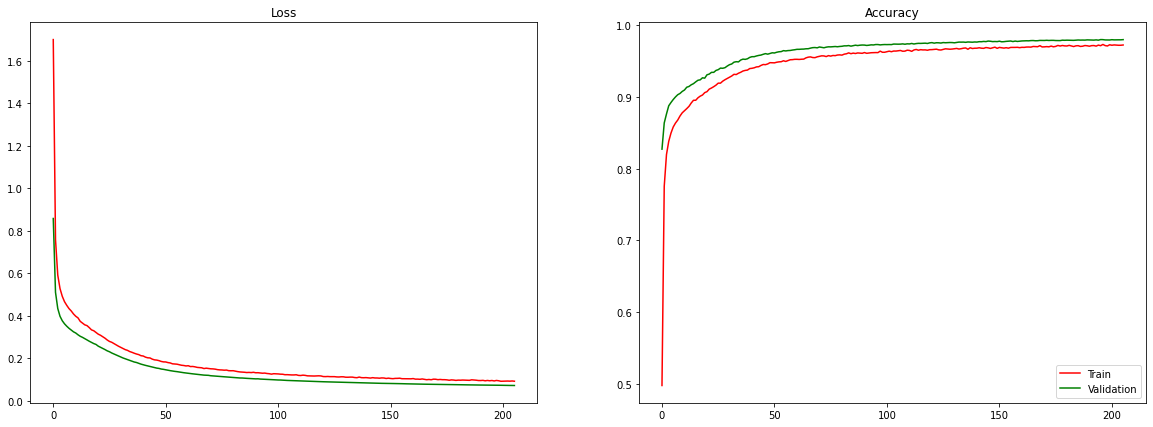

In [0]:
fig, (loss_ax, acc_ax) = plt.subplots(1, 2, figsize=(20,7))

loss_ax.set_title('Loss')
loss_ax.plot(mnist_conv_drop_model_train.history['loss'], '-r', label='Train')
loss_ax.plot(mnist_conv_drop_model_train.history['val_loss'], '-g', label='Validation')

acc_ax.set_title('Accuracy')
acc_ax.plot(mnist_conv_drop_model_train.history['accuracy'], '-r', label='Train')
acc_ax.plot(mnist_conv_drop_model_train.history['val_accuracy'], '-g', label='Validation')

plt.legend(loc=4)
plt.show()

And we can assess the performance on the test set:

In [0]:
mnist_conv_drop_model.load_weights('mnist_conv_drop_best.h5')
loss, acc = mnist_conv_drop_model.evaluate(mnist_test_x, mnist_test_y)
print('Accuracy: {}'.format(acc))

313/313 [==============================] - 2s 7ms/step - loss: 0.0629 - accuracy: 0.9808
Accuracy: 0.9807999730110168


##### Combined L2 + dropout

In [0]:
mnist_l2_drop_model = tf.keras.Sequential(name='mnist_cnn_l2_dropout')
mnist_l2_drop_model.add(tf.keras.layers.Input(mnist_info.features['image'].shape))
mnist_l2_drop_model.add(tf.keras.layers.Conv2D(filters=16, kernel_size=4, activation='relu', padding='same', name='convolution', kernel_regularizer=tf.keras.regularizers.l2(0.01)))
mnist_l2_drop_model.add(tf.keras.layers.MaxPool2D(pool_size=2, name='pooling'))
mnist_l2_drop_model.add(tf.keras.layers.Dropout(0.5, name='dropout'))
mnist_l2_drop_model.add(tf.keras.layers.Flatten(name='flatten'))
mnist_l2_drop_model.add(tf.keras.layers.Dense(mnist_info.features['label'].num_classes, activation='softmax', name='output'))
mnist_l2_drop_model.compile(loss='sparse_categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])
mnist_l2_drop_model.summary()

Model: "mnist_cnn_l2_dropout"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
convolution (Conv2D)         (None, 28, 28, 16)        272       
_________________________________________________________________
pooling (MaxPooling2D)       (None, 14, 14, 16)        0         
_________________________________________________________________
dropout (Dropout)            (None, 14, 14, 16)        0         
_________________________________________________________________
flatten (Flatten)            (None, 3136)              0         
_________________________________________________________________
output (Dense)               (None, 10)                31370     
Total params: 31,642
Trainable params: 31,642
Non-trainable params: 0
_________________________________________________________________


In [0]:
earlystop = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=10, verbose=1)
checkpoint = tf.keras.callbacks.ModelCheckpoint('mnist_l2_drop_best.h5', monitor='val_accuracy', verbose=1, save_best_only=True)

mnist_conv_l2_drop_model_train = mnist_l2_drop_model.fit(mnist_train_x, mnist_train_y, validation_split=0.2, callbacks=[earlystop,checkpoint], epochs=10000, batch_size=256)

Epoch 1/10000
187/188 [============================>.] - ETA: 0s - loss: 1.7256 - accuracy: 0.5061
Epoch 00001: val_accuracy improved from -inf to 0.81567, saving model to mnist_l2_drop_best.h5
188/188 [==============================] - 18s 95ms/step - loss: 1.7237 - accuracy: 0.5067 - val_loss: 0.9113 - val_accuracy: 0.8157
Epoch 2/10000
187/188 [============================>.] - ETA: 0s - loss: 0.7784 - accuracy: 0.7840
Epoch 00002: val_accuracy improved from 0.81567 to 0.86175, saving model to mnist_l2_drop_best.h5
188/188 [==============================] - 18s 94ms/step - loss: 0.7783 - accuracy: 0.7839 - val_loss: 0.5592 - val_accuracy: 0.8618
Epoch 3/10000
187/188 [============================>.] - ETA: 0s - loss: 0.6171 - accuracy: 0.8242
Epoch 00003: val_accuracy improved from 0.86175 to 0.87533, saving model to mnist_l2_drop_best.h5
188/188 [==============================] - 18s 95ms/step - loss: 0.6170 - accuracy: 0.8243 - val_loss: 0.4846 - val_accuracy: 0.8753
Epoch 4/10000

In [0]:
mnist_l2_drop_model.load_weights('mnist_l2_drop_best.h5')
loss, acc = mnist_l2_drop_model.evaluate(mnist_test_x, mnist_test_y)
print('Accuracy: {}'.format(acc))

313/313 [==============================] - 2s 6ms/step - loss: 0.1498 - accuracy: 0.9713
Accuracy: 0.9713000059127808


In [0]:
fig, (loss_ax, acc_ax) = plt.subplots(1, 2, figsize=(20,7))

loss_ax.set_title('Loss')
loss_ax.plot(mnist_conv_l2_drop_model_train.history['loss'], '-r', label='Train')
loss_ax.plot(mnist_conv_l2_drop_model_train.history['val_loss'], '-g', label='Validation')

acc_ax.set_title('Accuracy')
acc_ax.plot(mnist_conv_l2_drop_model_train.history['accuracy'], '-r', label='Train')
acc_ax.plot(mnist_conv_l2_drop_model_train.history['val_accuracy'], '-g', label='Validation')

plt.legend(loc=4)
plt.show()